# Deep Convolutional Generative Adversarial Network Experiment on fashion_mnist dataset 

reference: https://www.tensorflow.org/tutorials/generative/dcgan#setup

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
tf.random.set_seed(512)

### Get the datas, experiment with the fashion mnist dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
# check the size of the data
len(x_train), len(y_train), len(x_test), len(y_test)

(60000, 60000, 10000, 10000)

### Visualize data

In [6]:
def explore_data(x_train, y_train, x_test, y_test):

    # define the class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # plot the distribution of classes in the training, validation, and test sets
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # plot the distribution of classes in the training set
    train_class_counts = np.bincount(y_train)
    ax[0].bar(range(10), train_class_counts)
    ax[0].set_xticks(range(10))
    ax[0].set_xticklabels(class_names, rotation=45)
    ax[0].set_title('Training set')

    # plot the distribution of classes in the test set
    test_class_counts = np.bincount(y_test)
    ax[1].bar(range(10), test_class_counts)
    ax[1].set_xticks(range(10))
    ax[1].set_xticklabels(class_names, rotation=45)
    ax[1].set_title('Test set')

    plt.show()

    print(" ")  # add space between figures

    # plot a sample of the images
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[y_train[i]])
    plt.show()

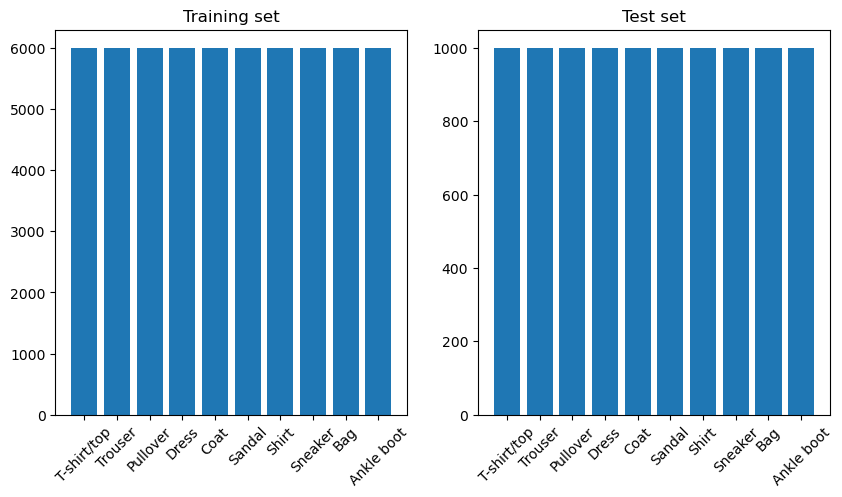

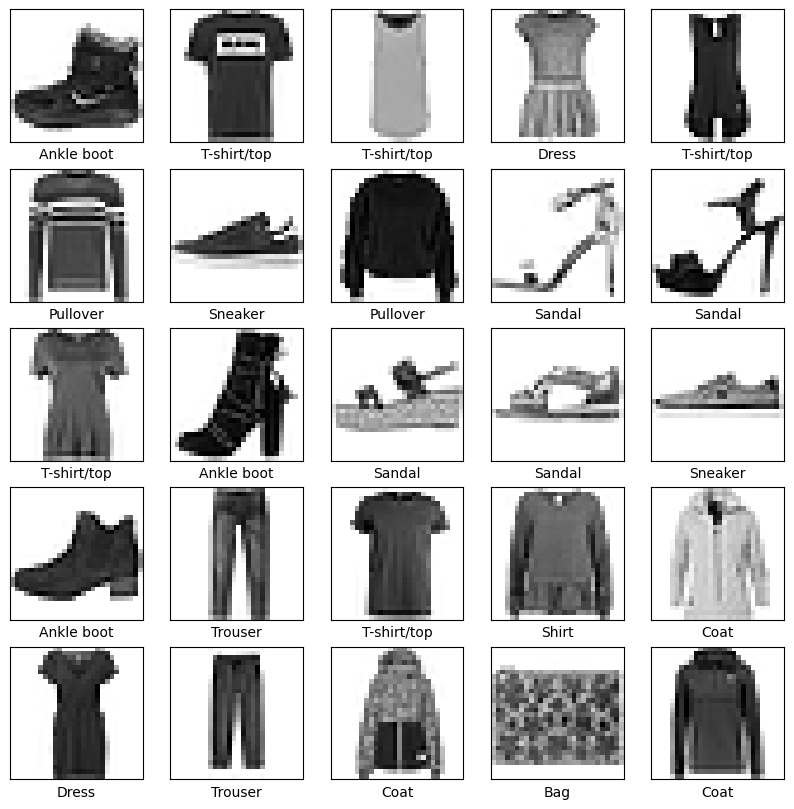

In [7]:
explore_data(x_train, y_train, x_test, y_test)

In [8]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [9]:
# Set up global variable
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

### Build the model

The Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

The generator takes 100 samples from the prior distribution (noise) as you can see from the input_shape. Then, it projects the data into a bigger dimension of 7 * 7 * 256 and reshape it to have feature maps of shape (7, 7, 256). Now the idea is by the end of the model, we want to decrease channels to 1 and increase the width and height to reach the original image size. The channels are controlled by the number of filters and that is why it is decreasing each consecutive Conv2DTranspose layer. it goes from 256 to 128, 64 and 1. For the width and height, they are controlled by strides parameter. With that, the first Conv2DTranspose doesn't change the width and height because it has strides of 1, however the second will multiple by 2, which yields to (14, 14) and again with the last Conv2DTranspose, which yields to (28, 28).

In [11]:
def build_generator(): 
    model = tf.keras.Sequential()
    # The model will first take 100 sample from the input shape, and it expand it into 7x7x256 dimension
    # and it has the feature of shape (7, 7, 256 now)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) 
    # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # Leaky relu can return negative numbers
    
    model.add(layers.Reshape((7, 7, 256)))
    # Check if the model output are true, if not the function will error out
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size 
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    # Check the output shape of previous layer
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # Leaky relu can return negative numbers
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # minimalize the size of the output until it output a images
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

Leaky Relu
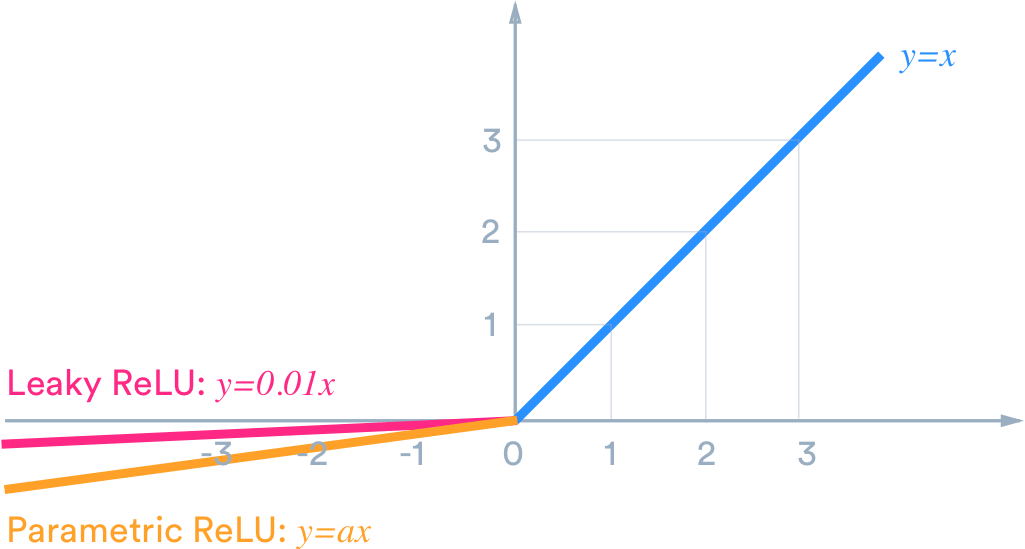

### Get an image with the untrained model

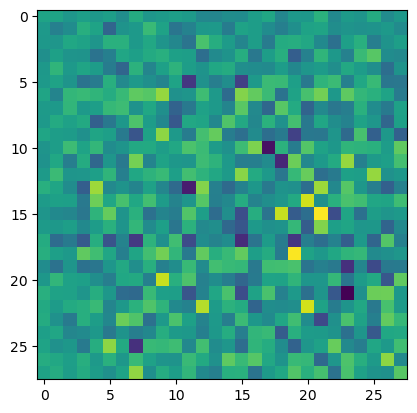

In [12]:
generator = build_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0])

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### The Discriminator
The discriminator is a CNN-based image classifier.


In [14]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [15]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00325371]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers


Define loss functions and optimizers for both models.

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [20]:
checkpoint_dir = './generation_model/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

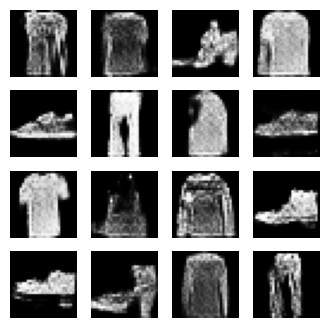

In [30]:
train(train_ds, EPOCHS)

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [32]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

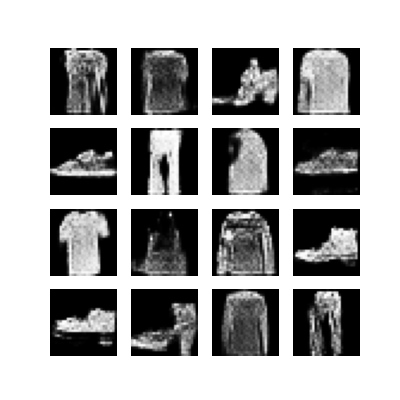

In [33]:
display_image(EPOCHS)

In [34]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\lzhan\AppData\Local\Temp\ipykernel_2952\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\lzhan\AppData\Local\Temp\ipykernel_2952\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



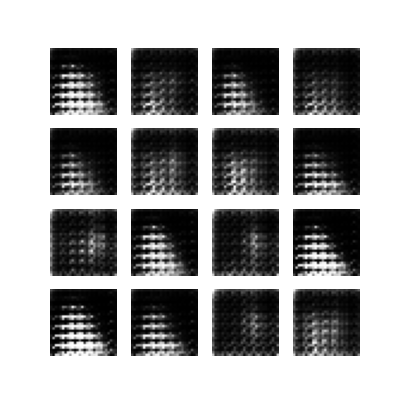

In [35]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)